# Advanced Machine Learning - programming assignment 3

*Due: Friday January 13*

*Grading: 10 points total*

**Please fill in:**
* Bais Giacomo (5355583)
* Carboni Leonardo (0279048)

### Further instructions:
* Make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* **Make sure to name the submitted file according to your and your collaborators last name.** (`submitter_collaborator.ipynb`)

## Structural causal models
In this programming assignment, we will look at data from a structural causal model, and see how we can estimate the causal effect of $X$ on $Y$ from these data. The model consists of three variables:

* $X$ is the treatment: the dosage of a drug taken by a patient;
* $Y$ is the outcome: a numerical score reflecting how well the patient recovered;
* $Z$ is an additional variable that summarizes relevant genetic information about a patient.

$Y$ and $Z$ are continuous (real-valued), while $X$ is discrete.

The following code generates and plots observational data from this model.

In [72]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

# The following three functions implement the structural equations of an SCM with three
# endogenous variables X, Y, and Z. Each endogenous variable in this SCM has one exogenous
# parent (unnamed) whose value is sampled by the corresponding function. Each of these
# functions operates on numpy arrays of length num_samples, where num_samples is the
# number of data points.
def f_Z(num_samples):
    return 4 * np.random.random(size=num_samples) + 4 * np.random.random(size=num_samples) # Z = 4 * runif + 4 * runif
def f_X(z, num_samples):
    x_cont = z + np.random.normal(loc=0.0, scale=1.0, size=num_samples) # X = Z + rnorm(0, 1)
    return np.clip(2 * np.around(0.5 * (x_cont)), 0, 10).astype(dtype=int)
def f_Y(z, x, num_samples):
    return 2*z - x + np.random.normal(loc=0.0, scale=0.4, size=num_samples) # Y = 2 * Z - X + rnorm(0, 0.4)

# Generate data from the observational distribution.
def generate_observational_data(num_samples):
    z = f_Z(num_samples)
    x = f_X(z, num_samples)
    y = f_Y(z, x, num_samples)
    return (x, y, z)

num_samples_obs = 1000

x, y, z = generate_observational_data(num_samples_obs)

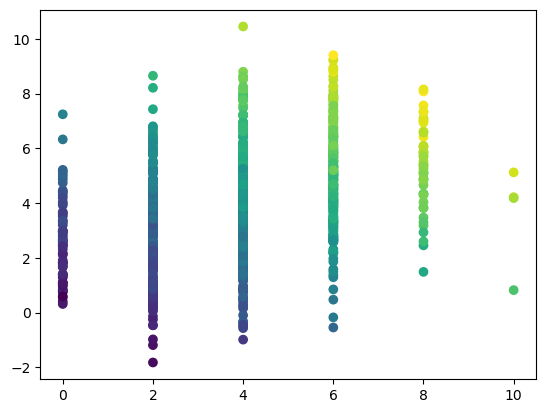

In [73]:
plt.scatter(x, y, c=z)
plt.show()

**Task 1 (1 point):** Use any supervised learning method of your choice to fit a function from $X$ to $Y$ to these data. (So $X$ is the only feature; $Z$ is not used. Note that you are *not* asked to validate or test your fit here.) Make a new plot that displays both the data points and your fitted function, for $x$ in the range $[0,10]$.


To plot a regression curve, first use a function like `np.linspace` to create an array of neatly ordered x-values. Then have your trained machine learning model predict the y-values corresponding to those x-values.

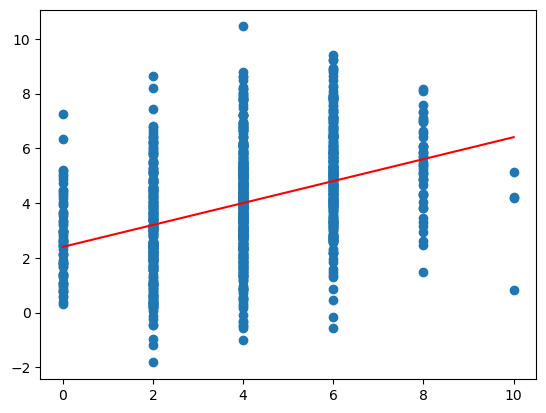

In [74]:
# Your code here
linear_regression = linear_model.LinearRegression().fit(x.reshape(-1,1), y)

linear_x = np.linspace(0,10).reshape(-1,1)
y_pred_linear = linear_regression.predict(linear_x)

plt.plot(linear_x, y_pred_linear, c="red")
plt.scatter(x, y)
plt.show()

Look at the code of `f_X`, `f_Y`, `f_Z`, and `generate_observational_data` to answer the following questions.

**Question 2 (1 point):** For each endogenous variable, what other endogenous variables are the direct causes? For each such relation between two variables, explain what the presence of this relation means in the real world, where the three variables represent treatment, outcome, and genetic information.

*Your answer here*
1. Z is a direct cause of X.
2. X and Z are direct causes of Y.
3. Z has no endogenous direct cause.

In the real world:
<!-- 1. May be interpreted as the treatment being given depending on the genetic information, as different patients may require different treatments.
2. May be interpreted as the outcome of the treatment being caused by the treatment itself and the genetic information, as both the efficacy of the treatment and how that specific patient will react to it are both decisive in the outcome. -->

* Treatment (X) as a cause of outcome: If treatment is an endogenous variable and it directly causes changes in the outcome, this could mean that the treatment is effective in producing the desired effect. For example, if a medication is being tested as a treatment for a particular condition, and the presence of the medication is found to be significantly associated with improvement in the condition, this would suggest that the treatment is effective.
* Genetic information is a cause of treatment and outcome: genetic information is an endogenous variable and it directly causes changes in treatment and outcome, this could mean that the treatment and outcome are being influenced by the patient's genetic makeup. For example, if a patient's genetic profile is found to be significantly associated with their response to a particular medication, this could suggest that the medication is more or less effective for individuals with certain genetic variations.

If outcome was a cause of treatment, this could mean that the treatment is being adjusted based on the observed effect.
It's important to note that these are just a few examples, and the relationships between endogenous variables can be much more complex in real-world situations. Causal relationships between variables can be difficult to determine, and it is often necessary to use statistical and other analytical methods to try to understand the nature of the relationship.

## Intervening on the system

Now we will consider what happens if we intervene on the system by prescribing certain dosages of the drug.

**Task 3 (1 point):** Complete the following function, which is analogous to the function `generate_observational_data`, except now instead of observational data, each data point $(x_i, y_i, z_i)$ should be generated from the interventional distribution with $do(X=x_i)$. The values $x_i$ are specified by the array `x`, which is the first argument of this function.

In [75]:
def generate_experimental_data(x, num_samples):
    # Generate data under intervention do(X=x[i]). x is a vector of length num_samples.
    # Your code here
    z = f_Z(num_samples)
    y = f_Y(z, x, num_samples) # non sono sicuro sia così semplice in realtà
    return (x, y, z)

We will look at interventional data where for each data point, the dosage is chosen uniformly at random from the set $\{0,2,4,8\}$, independently for each individual.

In [76]:
num_samples_exp = 200

# Set the values of x according to the distribution specified above, then generate the whole data
# under the intervention do(X=x).
x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)
(x_exp, y_exp, z_exp) = generate_experimental_data(x_exp, num_samples_exp)

**Task 4 (0.5 points):** Plot these experimental data in the same way as before, again including the curve you fit earlier to the observational data.

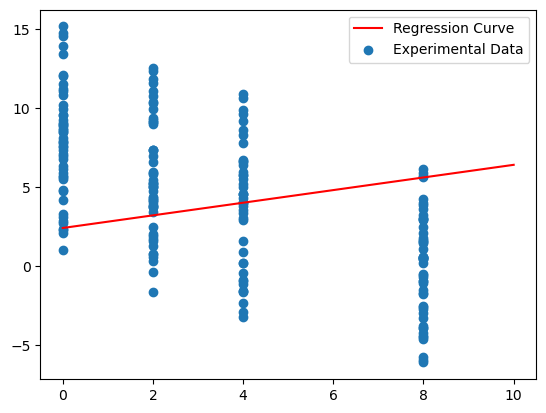

In [77]:
# Your code here
plt.plot(linear_x, y_pred_linear, c="red", label = 'Regression Curve')
plt.scatter(x_exp, y_exp, label = "Experimental Data")
plt.legend()
plt.show()

**Task 5 (0.5 points):** Compute the RMSE (root mean squared error) when you use the regression curve you learned earlier to predict $Y$ in these new data. (To put it another way: we used the observational data as training data, and now we are using the experimental data as test data.)

In [78]:
# Your code here
from sklearn.metrics import mean_squared_error

preds = linear_regression.predict(x_exp.reshape(-1, 1))
print(f"Mean Squared Error: {mean_squared_error(y_true = y_exp, y_pred = preds, squared = False)}")

Mean Squared Error: 5.4791995106119


You should see in your plot that the curve we learned from the observational data, does not seem to work well for predicting the outcome $Y$ in the interventional data. This is because the experimental distribution is different from the observational distribution.

**Question 6 (1 point):** Look at the product decompositions of the original SCM and the SCM modified by the intervention on $X$. Which factors in the decompositions are the same between the observational and the experimental distribution? And what conditional distribution (which may or may not appear in either product decomposition) needs to stay the same between the two distributions, in order for your fitted curve to also give good predictions on the experimental data?

*Your answer here*
The product decomposition of the original Structural Causal Model (SCM) is given by:

$P(Y,Z) = P(Y|Pa_Y) \prod_{X_i \in Pa_Y} P(X_i|Pa_{X_i})$

where $Pa_Y$ and $Pa_{X_i}$ denote the parents of the variables $Y$ and $X_i$ in the SCM, respectively.

The product decomposition of the SCM modified by the intervention on $X$ is given by:

$P(Y,Z) = P(Y|do(X=x), Z) \prod_{X_i \in Pa_Y, X_i \neq X} P(X_i|Pa_{X_i})$

In both of these product decompositions, the factors $P(Y|Pa_Y)$ and $\prod_{X_i \in Pa_Y} P(X_i|Pa_{X_i})$ appear in the original SCM, but not in the SCM modified by the intervention on $X$.

The conditional distribution that needs to stay the same between the observational and the experimental distributions, in order for the fitted curve to give good predictions on the experimental data, is the distribution $P(Y|do(X=x), Z)$. This is because the fitted curve is based on the statistical relationship between $Y$ and $X$ in the observational data, and this relationship needs to be preserved in the experimental data in order for the fitted curve to give good predictions on the experimental data.


**Question 7 (1.5 points):** What (marginal or conditional) independence should hold in the experimental data, based on d-separation? Plot the data in a way that illustrates this independence, and explain what property of the plot illustrates the independence.

*Your answer here*
Based on d-separation, the following (marginal or conditional) independence should hold in the experimental data:

$Y \perp Z | do(X=x)$

This independence states that $Y$ and $Z$ are independent given the intervention on $X$, or equivalently, that $Y$ and $Z$ are independent in the experimental data after the intervention on $X$ has been performed.

To illustrate this independence, we plot the data in a scatterplot where $Y$ is plotted on the y-axis and $Z$ is plotted on the x-axis. If the independence holds, we should not observe any systematic patterns or relationships between $Y$ and $Z$ in the plot. For example, we should not see a linear trend or a clustering of the data points.



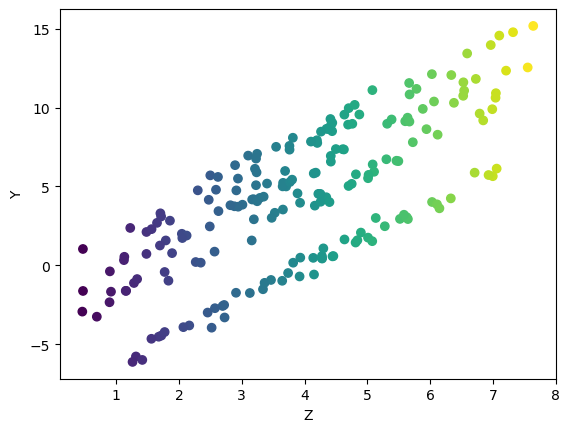

In [79]:
# Your code here
plt.scatter(z_exp, y_exp, c=z_exp)
plt.xlabel('Z')
plt.ylabel('Y')
plt.show()

**Task 8 (2 points):** Now, we will use the method of inverse probability weighing (section 3.6 in the book, covered in lecture 12) for this task. Using *only the observational data*, fit a logistic regression to predict $X$ using $Z$ as a feature. From this logistic regression, extract an estimate of $P(X=x_i|Z=z_i)$ for each data point $(x_i, y_i, z_i)$. (Consult the scikit-learn manual to learn how to do this.) Use these to compute an inverse probability weight for each data point in the observational data set.

Important note: the purpose of the logistic regression is *not* to predict the value of $X$, because we already know that value for each data point! But we do need the logistic regression to esimate the probability $P(X=x_i|Z=z_i)$.

In [80]:
# Create logistic regression object (using scikit-learn)
reg_logistic = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)

# Your code here
reg_logistic.fit(np.reshape(z, (-1, 1)), x)
predicted_probabilities = reg_logistic.predict_proba(np.reshape(z, (-1, 1)))

final_probs = []
for i, data in enumerate(x):
    d = int(data/2)
    final_probs.append(predicted_probabilities[i, d])

inverse_probability_weights = 1 / np.array(final_probs)

**Task 9 (1 point):** Now again predict $Y$ in terms of $X$ using only the observational data as training data, but this time weigh each data point with the inverse probability weight. (Machine learning libraries often provides a way to specify a weight for each data point when fitting a model to data; check the manual of the library you are using.) Plot your regression curve in the same plot as the experimental data, as before.

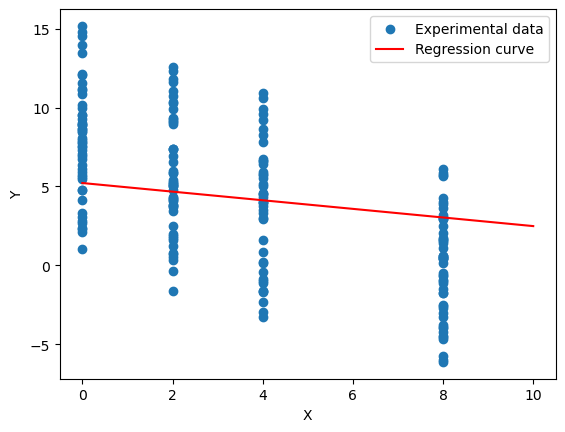

In [81]:
# Your code here
reg_linear2 = linear_model.LinearRegression()
reg_linear2.fit(x.reshape(-1, 1), y, sample_weight=inverse_probability_weights)
# Predict Y using the fitted model
predicted_y = reg_linear2.predict(linear_x.reshape(-1, 1))

# Plot the observational data and the regression curve
plt.scatter(x_exp, y_exp, label='Experimental data')
plt.plot(linear_x, predicted_y, c="red",label='Regression curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


**Task 10 (0.5 points):** To verify that these predictions of the causal effect of $X$ on $Y$ are more accurate, again compute the RMSE on the experimental data.

In [82]:
# Your code here
preds = reg_linear2.predict(x_exp.reshape(-1,1))
print(f"Mean Squared Error: {mean_squared_error(y_true = y_exp, y_pred = preds, squared = False)}")

Mean Squared Error: 4.1238887672650115


You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).